In [55]:
# Some minor setup for the notebook
import warnings
import nest_asyncio

# Ignore all warnings
warnings.filterwarnings("ignore")

# Allows for running async code in Jupyter notebooks
nest_asyncio.apply()

In [2]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [3]:
from datasets import load_dataset

ms_marco = load_dataset("microsoft/ms_marco", "v2.1")

In [33]:
import numpy as np
from sklearn.metrics import precision_score, recall_score


def ndcg(retrieved_list, relevant_list, k=None):
    def dcg(scores):
        return sum(score / (i + 1) for i, score in enumerate(scores))

    if k is None:
        k = len(retrieved_list)

    retrieved_scores = [1 if doc in relevant_list else 0 for doc in retrieved_list[:k]]
    ideal_scores = sorted(retrieved_scores, reverse=True)

    dcg_value = dcg(retrieved_scores)
    idcg_value = dcg(ideal_scores)

    return dcg_value / idcg_value if idcg_value > 0 else 0


def mean_reciprocal_rank(retrieved_list, relevant_list):
    ranks = []
    for relevant in relevant_list:
        try:
            rank = retrieved_list.index(relevant) + 1
        except ValueError:
            rank = len(retrieved_list) + 1  # Not found
        ranks.append(rank)
    return 1.0 / min(ranks) if ranks else 0.0


def calculate_ndcg(retrieved_list, relevant_list, k=None):
    def dcg(scores):
        return sum(score / (np.log2(idx + 2)) for idx, score in enumerate(scores))

    if k is None:
        k = len(retrieved_list)

    # Relevance scores for retrieved documents
    retrieved_scores = [1 if doc in relevant_list else 0 for doc in retrieved_list[:k]]
    # Ideal relevance scores
    ideal_scores = sorted(retrieved_scores, reverse=True)

    dcg_value = dcg(retrieved_scores)
    idcg_value = dcg(ideal_scores)

    return dcg_value / idcg_value if idcg_value > 0 else 0


def calculate_precision(retrieved_list, relevant_list):
    y_true = [1 if doc in relevant_list else 0 for doc in retrieved_list]
    y_pred = [1] * len(y_true)  # Assuming all retrieved documents are relevant for calculating precision
    return precision_score(y_true, y_pred, zero_division=0)


def calculate_recall(retrieved_list, relevant_list):
    y_true = [1 if doc in relevant_list else 0 for doc in relevant_list]
    y_pred = [1 if doc in retrieved_list else 0 for doc in relevant_list]
    return recall_score(y_true, y_pred, zero_division=0)


def compute_all_stats(retrieved_list, relevant_list):
    return {
        'MRR': mean_reciprocal_rank(retrieved_list, relevant_list),
        'nDCG': calculate_ndcg(retrieved_list, relevant_list, k=len(relevant_list)),
        'Precision': calculate_precision(retrieved_list, relevant_list),
        'Recall': calculate_recall(retrieved_list, relevant_list),
    }

In [5]:
# Use subset for demonstration
subset = ms_marco['train'].select(range(1000))

In [6]:
print(subset[2]['query'])

why did stalin want control of eastern europe


In [7]:
from langchain_community.retrievers import BM25Retriever
from langchain_core.documents import Document

In [8]:
# Prepare the documents for BM25
bm25_docs = [Document(page_content=passage) for data in subset for passage in data['passages']['passage_text']]

# Initialize BM25 Retriever
bm25_retriever = BM25Retriever.from_documents(bm25_docs)

In [17]:
import os
from ragstack_colbert import CassandraDatabase, ColbertEmbeddingModel

keyspace = "benchmarksmarco1000parallel"
database_id = os.getenv("ASTRA_DATABASE_ID")
astra_token = os.getenv("ASTRA_TOKEN")

database = CassandraDatabase.from_astra(
    astra_token=astra_token,
    database_id=database_id,
    keyspace=keyspace
)

embedding_model = ColbertEmbeddingModel()

[Jun 26, 10:12:08] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


In [45]:
from ragstack_langchain.colbert import ColbertVectorStore as LangchainColbertVectorStore

lc_vector_store = LangchainColbertVectorStore(
    database=database,
    embedding_model=embedding_model,
)

In [46]:
all_texts = []
all_metadatas = []
i = 0
for row in subset:
    all_texts.extend(row['passages']['passage_text'])
    all_metadatas.extend([{'row_id': i} for _ in row['passages']['is_selected']])
    i += 1


In [47]:
print("Number of texts:", len(all_texts))

Number of texts: 9992

In [ ]:
lc_vector_store.add_texts(all_texts, metadatas=all_metadatas)

In [49]:
import time
from tqdm import tqdm

In [61]:
colbert_retrieved_list = []
colbert_relevant_list = []
colbert_latencies = []
for row in tqdm(subset):
    query = row['query']
    n_results = len(row['passages']['is_selected'])
    before = time.time()
    raw_results = lc_vector_store.similarity_search(query, k=n_results)
    after = time.time()
    retrieved_list = [result.page_content for result in raw_results]
    relevant_list = row['passages']['passage_text']

    colbert_retrieved_list.append(retrieved_list)
    colbert_relevant_list.append(relevant_list)
    colbert_latencies.append(after - before)

100%|██████████| 1000/1000 [10:47<00:00,  1.54it/s]


In [62]:
# calculate stats
colbert_stats = [compute_all_stats(retrieved_list, relevant_list) for retrieved_list, relevant_list in
                 zip(colbert_retrieved_list, colbert_relevant_list)]
colbert_avg_latency = np.mean(colbert_latencies)

In [50]:
# Now test BM25
bm25_retrieved_list = []
bm25_relevant_list = []
bm25_latencies = []

for row in tqdm(subset):
    query = row['query']
    n_results = len(row['passages']['is_selected'])
    before = time.time()
    raw_results = bm25_retriever.invoke(query, k=n_results)
    after = time.time()
    retrieved_list = [result.page_content for result in raw_results]
    relevant_list = row['passages']['passage_text']

    bm25_retrieved_list.append(retrieved_list)
    bm25_relevant_list.append(relevant_list)
    bm25_latencies.append(after - before)


100%|██████████| 1000/1000 [00:06<00:00, 159.14it/s]


In [51]:
bm25_stats = [compute_all_stats(retrieved_list, relevant_list) for retrieved_list, relevant_list in
              zip(bm25_retrieved_list, bm25_relevant_list)]
bm25_avg_latency = np.mean(bm25_latencies)

In [18]:
import os
from pinecone import Pinecone, ServerlessSpec
from langchain_community.retrievers import (
    PineconeHybridSearchRetriever,
)

index_name = keyspace

In [19]:
# initialize Pinecone client
pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])

# create the index
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=1536,
        metric="dotproduct",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )

In [20]:
index = pc.Index(index_name)

In [21]:
from langchain_openai import OpenAIEmbeddings

openai_embeddings = OpenAIEmbeddings()

In [22]:
from pinecone_text.sparse import BM25Encoder

# or from pinecone_text.sparse import SpladeEncoder if you wish to work with SPLADE

# use default tf-idf values
bm25_encoder = BM25Encoder().default()

In [25]:
bm25_encoder.fit(all_texts)

cwd = os.getcwd()
bm25_encoder.dump(cwd + "/bm25_encoder.json")

  0%|          | 0/9992 [00:00<?, ?it/s]

In [28]:
pinecone_retriever = PineconeHybridSearchRetriever(
    embeddings=openai_embeddings, sparse_encoder=bm25_encoder, index=index
)

In [29]:
result = pinecone_retriever.invoke("What is the capital of France?", k=5)

In [31]:
print(result[:2])

[
    Document(
        page_content='France has been one of the most dominant agricultural centers of Europe for centuries. That 
gave France an important role in European and, to some extent world, affairs in the pre-industrial age.he major 
agricultural products that place France among the top producers in the world market are sugar beets, wine, milk, 
beef and veal, cereals, and oilseeds.',
        metadata={'row_id': 108.0}
    ),
    Document(
        page_content="The most important crop was wheat. Wheat was used to make flour. The farmers ground the wheat
grains in the seigneur's flour mill. They would pay the seigneur with part of the … flour for the use of his mill. 
France may be a small country in Western Europe, but the impact of French cu…. 2  The Weather in France Though 
France is only the size of Texas, it is situated in an area where weather varies greatly.",
        metadata={'row_id': 108.0}
    )
]

In [52]:
pinecone_retrieved_list = []
pinecone_relevant_list = []
pinecone_latencies = []
for row in tqdm(subset):
    query = row['query']
    n_results = len(row['passages']['is_selected'])
    before = time.time()
    raw_results = pinecone_retriever.invoke(query, k=n_results)
    after = time.time()
    retrieved_list = [result.page_content for result in raw_results]
    relevant_list = row['passages']['passage_text']

    pinecone_retrieved_list.append(retrieved_list)
    pinecone_relevant_list.append(relevant_list)
    pinecone_latencies.append(after - before)

100%|██████████| 1000/1000 [03:24<00:00,  4.89it/s]


In [53]:
# calculate stats
pinecone_stats = [compute_all_stats(retrieved_list, relevant_list) for retrieved_list, relevant_list in
                  zip(pinecone_retrieved_list, pinecone_relevant_list)]
pinecone_avg_latency = np.mean(pinecone_latencies)

In [63]:
# Print a table
from rich.table import Table

table = Table(title="ColBERT vs. BM25 vs. Pinecone Hybrid")

table.add_column("Metric")
table.add_column("ColBERT")
table.add_column("BM25")
table.add_column("Pinecone")

for metric in colbert_stats[0].keys():
    colbert_values = [stats[metric] for stats in colbert_stats]
    bm25_values = [stats[metric] for stats in bm25_stats]
    pinecone_values = [stats[metric] for stats in pinecone_stats]

    table.add_row(metric, f"{np.mean(colbert_values):.4f}", f"{np.mean(bm25_values):.4f}",
                  f"{np.mean(pinecone_values):.4f}")

# add latencies
table.add_row("Average Latency", f"{colbert_avg_latency:.4f}", f"{bm25_avg_latency:.4f}", f"{pinecone_avg_latency:.4f}")

print(table)

      ColBERT vs. BM25 vs. Pinecone Hybrid       
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Metric          ┃ ColBERT ┃ BM25   ┃ Pinecone ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ MRR             │ 0.9825  │ 0.7442 │ 0.9825   │
│ nDCG            │ 0.9699  │ 0.7141 │ 0.9816   │
│ Precision       │ 0.7040  │ 0.5220 │ 0.9390   │
│ Recall          │ 0.7021  │ 0.2086 │ 0.3769   │
│ Average Latency │ 0.6468  │ 0.0062 │ 0.2031   │
└─────────────────┴─────────┴────────┴──────────┘

In [76]:
import os
import weaviate
from dotenv import load_dotenv

load_dotenv(override=True)

auth_config = weaviate.AuthApiKey(api_key=os.environ['WCS_API_KEY'])
client = weaviate.Client(
    url=os.environ['WCS_URL'],
    auth_client_secret=auth_config,
    additional_headers={
        "X-Openai-Api-Key": os.environ["OPENAI_API_KEY"],
    },
)
embeddings = OpenAIEmbeddings()

In [77]:
from langchain_community.retrievers import (
    WeaviateHybridSearchRetriever,
)


def generate_weaviate_retriever(n_results):
    weaviate_retriever = WeaviateHybridSearchRetriever(
        client=client,
        index_name="LangChain",
        text_key="text",
        create_schema_if_missing=True,
        k=n_results
    )
    return weaviate_retriever

In [78]:
print(generate_weaviate_retriever(5).invoke("What is the capital of France?"))

[
    Document(
        page_content='One-third of France’s land is crop growing. Wheat is the major single crop grown at large 
farms in the Paris Basin and in the north.In southern France, most of the grapes produced are used in making wine 
being of high quality that come from several regions.In the Mediterranean region, grapes are used for cheaper 
wines.heat is the major single crop grown at large farms in the Paris Basin and in the north. In southern France, 
most of the grapes produced are used in making wine being of high quality that come from several regions.'
    ),
    Document(
        page_content='France has been one of the most dominant agricultural centers of Europe for centuries. That 
gave France an important role in European and, to some extent world, affairs in the pre-industrial age.he major 
agricultural products that place France among the top producers in the world market are sugar beets, wine, milk, 
beef and veal, cereals, and oilseeds.'
    ),
    Document(
        page_content='Food of France-a regional guide. You are here: French recipes French foods by region. When 
people talk of French food in restaurants they are usually referring to sophistication, fine food and wine and 
expensive restaurants.outh-West France: In the south-west of France the emphasis is on rich foods. The main 
specialities are duck, foie gras, prunes, oysters, mushrooms and truffles. And of course a nice rich red Bordeaux 
wine to go with it.'
    ),
    Document(
        page_content='It takes second place in both the EU and the world in the production of its highly popular 
wine varieties, with 5.3 million metric tons. Though fifth in the world, France ranks second in the EU in milk 
production, totaling 23.3 million metric tons.he major agricultural products that place France among the top 
producers in the world market are sugar beets, wine, milk, beef and veal, cereals, and oilseeds.'
    ),
    Document(
        page_content="The most important crop was wheat. Wheat was used to make flour. The farmers ground the wheat
grains in the seigneur's flour mill. They would pay the seigneur with part of the … flour for the use of his mill. 
France may be a small country in Western Europe, but the impact of French cu…. 2  The Weather in France Though 
France is only the size of Texas, it is situated in an area where weather varies greatly."
    )
]

In [79]:
weaviate_retrieved_list = []
weaviate_relevant_list = []
weaviate_latencies = []

for row in tqdm(subset):
    query = row['query']
    n_results = len(row['passages']['is_selected'])
    weaviate_retriever = generate_weaviate_retriever(n_results)
    success = False
    while not success:
        try:
            before = time.time()
            raw_results = weaviate_retriever.invoke(query)
            after = time.time()
            success = True
        except Exception as e:
            print(e)
    retrieved_list = [result.page_content for result in raw_results]
    relevant_list = row['passages']['passage_text']

    weaviate_retrieved_list.append(retrieved_list)
    weaviate_relevant_list.append(relevant_list)
    weaviate_latencies.append(after - before)

100%|██████████| 1000/1000 [11:22<00:00,  1.47it/s]


In [80]:
# calculate stats
weaviate_stats = [compute_all_stats(retrieved_list, relevant_list) for retrieved_list, relevant_list in
                  zip(weaviate_retrieved_list, weaviate_relevant_list)]

weaviate_avg_latency = np.mean(weaviate_latencies)

In [90]:
# Print a table
from rich.table import Table

metrics = ["Metric"] + list(colbert_stats[0].keys()) + ["Average Latency"]
colbert_values = ["ColBERT"] + [f"{np.mean([stats[metric] for stats in colbert_stats]):.4f}" for metric in
                                colbert_stats[0].keys()] + [f"{colbert_avg_latency:.4f}"]
bm25_values = ["BM25"] + [f"{np.mean([stats[metric] for stats in bm25_stats]):.4f}" for metric in
                          bm25_stats[0].keys()] + [f"{bm25_avg_latency:.4f}"]
pinecone_values = ["Pinecone"] + [f"{np.mean([stats[metric] for stats in pinecone_stats]):.4f}" for metric in
                                  pinecone_stats[0].keys()] + [f"{pinecone_avg_latency:.4f}"]
weaviate_values = ["Weaviate"] + [f"{np.mean([stats[metric] for stats in weaviate_stats]):.4f}" for metric in
                                  weaviate_stats[0].keys()] + [f"{weaviate_avg_latency:.4f}"]

# Create new table with transposed structure
table = Table(title="Metric Comparison:\nColBERT vs. BM25 vs. Pinecone Hybrid vs. Weaviate Hybrid")

# Adding columns
for col in metrics:
    table.add_column(col)

# Adding rows
table.add_row(*colbert_values)
table.add_row(*bm25_values)
table.add_row(*pinecone_values)
table.add_row(*weaviate_values)

print(table)
print("Note: the ColBERT # of candidates was set to half the length of the query embedding.")

                         Metric Comparison:                          
      ColBERT vs. BM25 vs. Pinecone Hybrid vs. Weaviate Hybrid       
┏━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ MRR    ┃ nDCG   ┃ Precision ┃ Recall ┃ Average Latency ┃
┡━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ ColBERT  │ 0.9825 │ 0.9699 │ 0.7040    │ 0.7021 │ 0.6468          │
│ BM25     │ 0.7442 │ 0.7141 │ 0.5220    │ 0.2086 │ 0.0062          │
│ Pinecone │ 0.9825 │ 0.9816 │ 0.9390    │ 0.3769 │ 0.2031          │
│ Weaviate │ 0.9805 │ 0.9775 │ 0.8120    │ 0.8108 │ 0.5371          │
└──────────┴────────┴────────┴───────────┴────────┴─────────────────┘

Note: the ColBERT # of candidates was set to half the length of the query embedding.

Text(0.5, 1.0, 'Latency Distribution for ColBERT, BM25,\nPinecone Hybrid, and Weaviate Hybrid Searches')

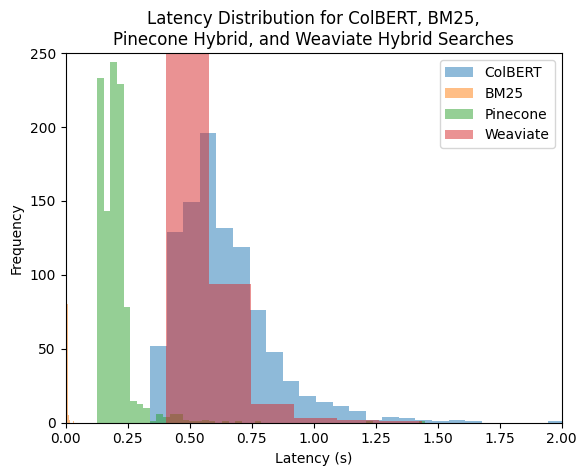

In [88]:
# Plot the latency distribution
import matplotlib.pyplot as plt

plt.hist(colbert_latencies, bins=50, alpha=0.5, label='ColBERT')
plt.hist(bm25_latencies, bins=50, alpha=0.5, label='BM25')
plt.hist(pinecone_latencies, bins=50, alpha=0.5, label='Pinecone')
plt.hist(weaviate_latencies, bins=50, alpha=0.5, label='Weaviate')
plt.legend(loc='upper right')
plt.xlabel('Latency (s)')
plt.ylabel('Frequency')
plt.xlim([0, 2])
plt.ylim([0, 250])
plt.title('Latency Distribution for ColBERT, BM25,\nPinecone Hybrid, and Weaviate Hybrid Searches')

In [84]:
# Save the stats to a json file
import json

cwd = os.getcwd()

with open(f"{cwd}/testing_stats.json", "w") as f:
    json.dump({"ColBERT": colbert_stats, "BM25": bm25_stats, "Pinecone": pinecone_stats, "Weaviate": weaviate_stats}, f)

print("Stats saved to testing_stats.json")

Stats saved to testing_stats.json

In [85]:
# Load the stats from the json file
import json
import os

cwd = os.getcwd()
with open(f"{cwd}/testing_stats.json", "r") as f:
    stats = json.load(f)

In [14]:
print(stats.keys())
colbert_stats = stats["ColBERT"]
bm25_stats = stats["BM25"]
pinecone_stats = stats["Pinecone"]
weaviate_stats = stats["Weaviate"]

dict_keys(['ColBERT', 'BM25'])

In [109]:
import sys

sys.path.append(os.path.abspath('ragstack-ai-colbert-pre-score/libs/colbert'))

# The following lines might appear as an error, but they should run correctly.
from ragstack_colbert_2.colbert_retriever import ColbertRetriever as ColbertRetriever2
from ragstack_colbert_2.colbert_embedding_model import ColbertEmbeddingModel as ColbertEmbeddingModel2
from ragstack_colbert_2 import CassandraDatabase as CassandraDatabase2

In [110]:
new_database = CassandraDatabase2.from_astra(
    astra_token=astra_token,
    database_id=database_id,
    keyspace=keyspace
)

embedding_model = ColbertEmbeddingModel()

In [111]:
new_colbert_retriever = ColbertRetriever2(
    database=new_database,
    embedding_model=ColbertEmbeddingModel2(),
)

In [112]:
new_colbert_retriever.text_search("What is France known for?", k=5)


#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . What is France known for?, 		 True, 		 None
#> Output IDs: torch.Size([9]), tensor([ 101,    1, 2054, 2003, 2605, 2124, 2005, 1029,  102])
#> Output Mask: torch.Size([9]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])



[(Chunk(doc_id='6f9508ec-3db0-48aa-909e-9a21551b9566', chunk_id=18, text='Our calendars. 1  FestivalsExplore the many festivals that Montral is known for. 2  Accs Culture networkDiscover shows and exhibitions presented by Montrals municipal arts and culture network. 3  Major sporting events (in French)Every year, Montral hosts a number of major sporting events!', metadata={'row_id': '17.0'}, embedding=None),
  5.309963345527649),
 (Chunk(doc_id='67b09287-c902-4d5c-8472-0b0b2f892dce', chunk_id=1, text='France has been one of the most dominant agricultural centers of Europe for centuries. That gave France an important role in European and, to some extent world, affairs in the pre-industrial age.he major agricultural products that place France among the top producers in the world market are sugar beets, wine, milk, beef and veal, cereals, and oilseeds.', metadata={'row_id': '108.0'}, embedding=None),
  5.052829682826996),
 (Chunk(doc_id='67b09287-c902-4d5c-8472-0b0b2f892dce', chunk_id=2, 

In [119]:
def test_colbert_at(multiplier):
    colbert_new_retrieved_list = []
    colbert_new_relevant_list = []
    colbert_new_latencies = []
    
    for row in tqdm(subset):
        query = row['query']
        n_results = len(row['passages']['is_selected'])
        before = time.time()
        raw_results = new_colbert_retriever.text_search(query, k=n_results, multiplier=multiplier)
        after = time.time()
        retrieved_list = [result[0].text for result in raw_results]
        relevant_list = row['passages']['passage_text']
    
        colbert_new_retrieved_list.append(retrieved_list)
        colbert_new_relevant_list.append(relevant_list)
        colbert_new_latencies.append(after - before)
        
    # calculate stats
    colbert_new_stats = [compute_all_stats(retrieved_list, relevant_list) for retrieved_list, relevant_list in zip(colbert_new_retrieved_list, colbert_new_relevant_list)]
    colbert_new_avg_latency = np.mean(colbert_new_latencies)
    colbert_new_stats["Average Latency"] = colbert_new_avg_latency
    
    return colbert_new_stats
    

In [ ]:
stat_dict = {}

for multiplier in [0.1, 0.25, 0.5, 1, 2, 3, 4, 5]:
    print("Testing multiplier:", multiplier)
    stats = test_colbert_at(multiplier)
    stat_dict[multiplier] = stats

Testing multiplier: 0.1

 20%|█▉        | 198/1000 [01:33<05:37,  2.37it/s]